## Time Series
Mathieu Laversin Alexandra Mille-Egea Ryan Pégoud

November 2022

In this work, we will apply the theory learned in Time Series on the next dataset : https://www.kaggle.com/datasets/francoisraucent/western-europe-power-consumption

In this Western Europe Power Consumption dataset, we will study the France consumption and try to predict it over months. The consumption is given in Megawatts (MW) and goes from January 2015 up to August 2020. The periodicity is about 1 hour between each sample.

In order to get the possibility to check our results, we will predict the power consumption in France in 2020.

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [42]:
df = pd.read_csv('fr.csv')
df.head()

,start,end,load
0,2015-01-01 00:00:00+00:00,2015-01-01 01:00:00+00:00,70929.0
1,2015-01-01 01:00:00+00:00,2015-01-01 02:00:00+00:00,69773.0
2,2015-01-01 02:00:00+00:00,2015-01-01 03:00:00+00:00,66417.0
3,2015-01-01 03:00:00+00:00,2015-01-01 04:00:00+00:00,64182.0
4,2015-01-01 04:00:00+00:00,2015-01-01 05:00:00+00:00,63859.0


# **Descriptive analysis**

In [43]:
df.describe()

,load
count,48870.000000
mean,53556.308267
std,11682.584881
min,29398.000000
25%,44616.000000
50%,51932.000000
75%,61629.750000
max,158000.000000


# **Down sampling**

In [44]:
df['start'] = pd.to_datetime(df['start'], format='%Y/%m/%d %H:%M:%S')
df['end'] = pd.to_datetime(df['end'], format='%Y/%m/%d %H:%M:%S')

df.set_index('start', inplace=True)
df

,end,load
start,,
2015-01-01 00:00:00+00:00,2015-01-01 01:00:00+00:00,70929.0
2015-01-01 01:00:00+00:00,2015-01-01 02:00:00+00:00,69773.0
2015-01-01 02:00:00+00:00,2015-01-01 03:00:00+00:00,66417.0
2015-01-01 03:00:00+00:00,2015-01-01 04:00:00+00:00,64182.0
2015-01-01 04:00:00+00:00,2015-01-01 05:00:00+00:00,63859.0
...,...,...
2020-07-31 19:00:00+00:00,2020-07-31 20:00:00+00:00,46001.0
2020-07-31 20:00:00+00:00,2020-07-31 21:00:00+00:00,47535.0
2020-07-31 21:00:00+00:00,2020-07-31 22:00:00+00:00,47322.0


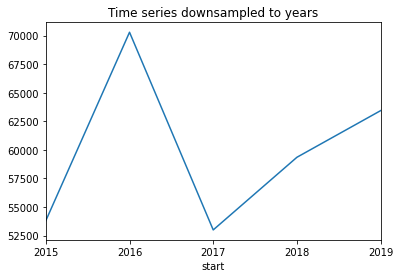

In [45]:
df["load"].asfreq('Y').plot()
plt.title('Time series downsampled to years')
plt.show()

In [46]:
df['year'] = pd.DatetimeIndex(df.index).year
yearly = df.groupby('year').agg('sum')
yearly

,load
year,
2015,470012917.0
2016,477474024.0
2017,475934939.0
2018,470394794.0
2019,467000414.0
2020,256479697.0


# **Monthly Moving Averages**

In [47]:
df['month'] = pd.DatetimeIndex(df.index).month
df_month_year= df.groupby(['year','month']).agg('mean')
df_month_year

load
year month              
2015 1      69523.116935
     2      71374.474702
     3      60624.438172
     4      50608.841667
     5      45209.040377
...                  ...
2020 3      55252.318489
     4      42409.579167
     5      40946.911290
     6      42225.624478
     7      44123.798387

[67 rows x 1 columns]

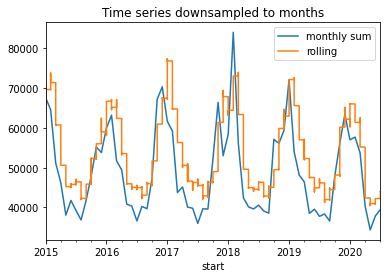

In [48]:
df["load"].asfreq('M').plot(label='monthly sum')

rolling_load = df.load.rolling('30D').mean()
rolling_load.plot(label='rolling')
plt.legend()
plt.title('Time series downsampled to months')
plt.show()

# **Seasonality**

In [49]:
melted_y_m = df.melt(id_vars=['year','month'], value_vars='load').drop('variable',axis=1)
melted_means = melted_y_m.groupby(['year','month']).agg('mean')
melted_means

value
year month              
2015 1      69523.116935
     2      71374.474702
     3      60624.438172
     4      50608.841667
     5      45209.040377
...                  ...
2020 3      55252.318489
     4      42409.579167
     5      40946.911290
     6      42225.624478
     7      44123.798387

[67 rows x 1 columns]

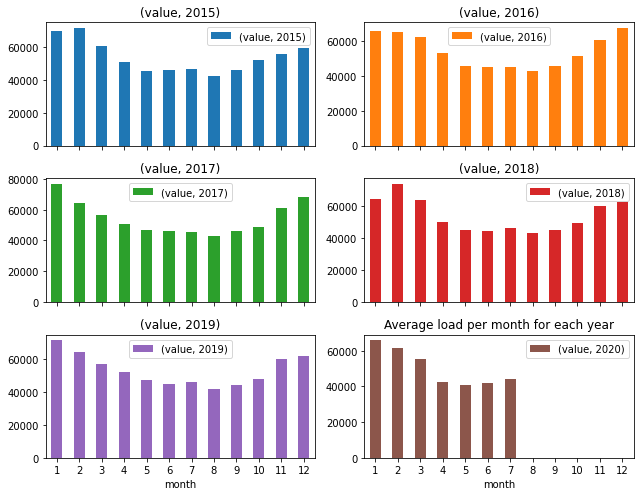

In [50]:
melted_means.unstack(level=0).plot(kind='bar', subplots=True, rot=0, figsize=(9, 7), layout=(3,2))
plt.title('Average load per month for each year')
plt.tight_layout()

In [51]:
melted_means['year'] = [melted_means.index[i][0] for i in range(melted_means.shape[0])]

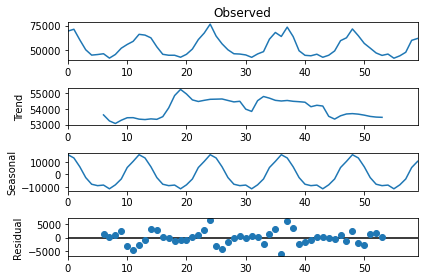

In [52]:
import statsmodels.api as sm

values = melted_means[melted_means['year']<2020]['value'] # monthly means between 2015 and 2019 (2020 is incomplete)
values = np.array(values, dtype=object)
decomposed = sm.tsa.seasonal_decompose(values, period=12) # yearly seasonality
decomposed.plot()
plt.show()

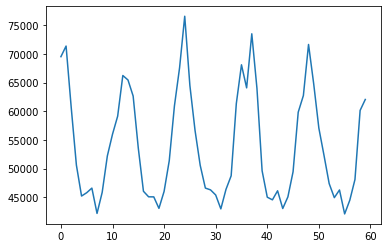

In [53]:
plt.plot(values)

In [54]:
train = melted_means[melted_means['year']<2018]
test = melted_means[melted_means['year'].between(2018,2020)]

In [55]:
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# model = ExponentialSmoothing(values, trend='add')
# model_fit = model.fit()
# yhat = model_fit.predict(...)

The training dataset has the dates from January 1st 2015 to December 31th, 2017, and the testing dataset has the dates from January 1st, 2018 to July 31, 2020.

In [56]:
# check shape
print(train.shape)
print(test.shape)

(36, 2)
(31, 2)


In [57]:
# Check the start and end time of the training and testing dataset
print('The start time of the training dataset is ', train['year'].min())
print('The end time of the training dataset is ', train['year'].max())
print('The start time of the testing dataset is ', test['year'].min())
print('The end time of the testing dataset is ', test['year'].max())


The start time of the training dataset is  2015
The end time of the training dataset is  2017
The start time of the testing dataset is  2018
The end time of the testing dataset is  2020


In [110]:
# read csv again (to convert it after in the good format for the prophet model)
df_ds = pd.read_csv('fr.csv')
df_ds.head()
df_ds=df_ds.drop(["end"], axis=1)


In [111]:
df_ds['start'] = pd.to_datetime(df_ds['start'], format='%Y/%m/%d %H:%M:%S')
df_ds.set_index('start', inplace=False)
df_ds

,start,load
0,2015-01-01 00:00:00+00:00,70929.0
1,2015-01-01 01:00:00+00:00,69773.0
2,2015-01-01 02:00:00+00:00,66417.0
3,2015-01-01 03:00:00+00:00,64182.0
4,2015-01-01 04:00:00+00:00,63859.0
...,...,...
48865,2020-07-31 19:00:00+00:00,46001.0
48866,2020-07-31 20:00:00+00:00,47535.0
48867,2020-07-31 21:00:00+00:00,47322.0
48868,2020-07-31 22:00:00+00:00,42805.0


In [112]:
# data re-sampled based on each day
df_ds = df_ds.resample('D', on='start').load.sum()


In [113]:
# reconvert to dataframe
df_ds = pd.DataFrame(df_ds)
df_ds.head()

,load
start,
2015-01-01 00:00:00+00:00,1592885.0
2015-01-02 00:00:00+00:00,1637422.0
2015-01-03 00:00:00+00:00,1510660.0
2015-01-04 00:00:00+00:00,1404165.0
2015-01-05 00:00:00+00:00,1708152.0


In [115]:
# rename columns for prophet model
df_ds = df_ds.reset_index()
df_ds.columns = ['ds', 'y']
df_ds.head()

,ds,y
0,2015-01-01 00:00:00+00:00,1592885.0
1,2015-01-02 00:00:00+00:00,1637422.0
2,2015-01-03 00:00:00+00:00,1510660.0
3,2015-01-04 00:00:00+00:00,1404165.0
4,2015-01-05 00:00:00+00:00,1708152.0


In [123]:
# remove timezone
def remove_timezone(df):
   
    # HERE `df` is a python datetime
    # object that used .replace() method
    return df.replace(tzinfo=None)
    
df_ds['ds'] = df_ds['ds'].apply(remove_timezone)

In [125]:
train_end_date = '2018-01-01'

# Train test split
train = df_ds[df_ds['ds'] <= train_end_date]
test = df_ds[df_ds['ds'] > train_end_date]

In [126]:
# create a first model

# Prophet model for time series forecast
!pip install prophet
from prophet import Prophet
# Use the default hyperparameters to initiate the Prophet model
model_baseline = Prophet()# Fit the model on the training dataset
model_baseline.fit(train)

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\alexa\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\prophet\\stan_model\\cmdstan-2.26.1\\stan\\lib\\stan_math\\lib\\tbb_2019_U8\\include\\tbb\\internal\\_flow_graph_tagged_buffer_impl.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths

18:20:50 - cmdstanpy - INFO - Chain [1] start processing


  Using cached prophet-1.1.1-cp310-cp310-win_amd64.whl (12.1 MB)

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: C:\Users\alexa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


18:20:50 - cmdstanpy - INFO - Chain [1] done processing


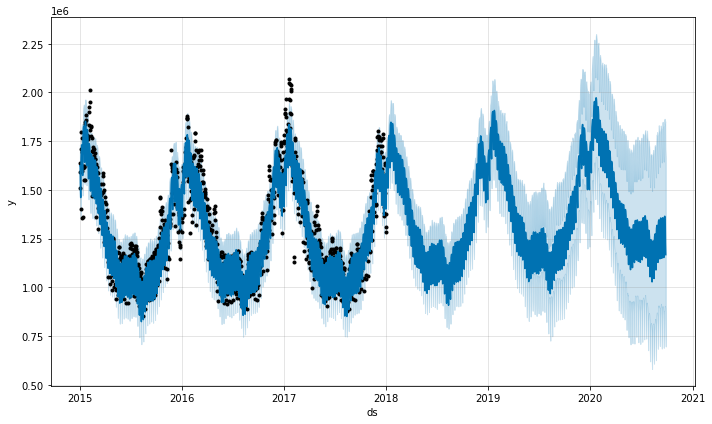

In [133]:
# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=1000) # Make prediction
forecast_baseline = model_baseline.predict(future_baseline)# Visualize the forecast
model_baseline.plot(forecast_baseline); # Add semi-colon to remove the duplicated chart